### Cel Pracy
Celem pracy jest stworzenie modelu, który będzie rozpoznawał czy otrzymana wiadomość email jest spamem czy nie. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import cross_val_score,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
import nltk
from nltk.corpus import stopwords
import string

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

pd.options.display.float_format = "{:.3f}".format
pd.set_option('display.max_columns',100)


In [2]:
# funckje

def counts_pct(category,data):
    '''Funkcja, która zwraca dla tanej kategori liczbe wartości, oraz wartość procentową'''
    base = data[category].value_counts()
    pct = base/data[category].shape[0] * 100
    joined = pd.concat([base,pct],axis=1)
    joined.columns = [str(category),str(category) + ' %']
    return joined

def annotate(ax,s="%.0f",suffix=''):
    for p in ax.patches:
        ax.annotate(s % p.get_height() + suffix, 
                 (p.get_x() + p.get_width() / 2,
                  p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
        
def despine(rot=0):
    sns.despine(left=True)
    plt.xticks(rotation = rot);
    plt.xlabel('');
    plt.ylabel('');

    
    
clr = ['#b3b7b8','#c55572']


In [3]:
data = pd.read_csv('spam.csv',sep=',',encoding='latin-1')
data = data[['v1','v2']]
data.columns = ['spam','text']

In [4]:
data.head(5)

spam                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

In [5]:
data['text']

0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                Will Ì_ b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: text, Length: 5572, dtype: object

In [6]:
data.shape

(5572, 2)

In [7]:
counts_pct(category='spam',data=data)

spam  spam %
ham   4825  86.594
spam   747  13.406

In [8]:
data.groupby('spam').describe()

text                                                               
     count unique                                                top freq
spam                                                                     
ham   4825   4516                             Sorry, I'll call later   30
spam   747    653  Please call our customer service representativ...    4

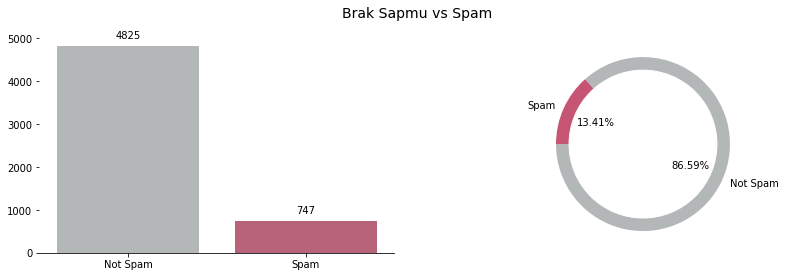

In [9]:
f,ax = plt.subplots(1,2,figsize=(14,4))
b1 = sns.countplot(x=data['spam'],palette=clr,ax=ax[0])
annotate(b1)
despine()
b1.set_xticklabels(['Not Spam','Spam'])
my_circle=plt.Circle( (0,0), 0.85, color='white')
size=data['spam'].value_counts().tolist()
plt.pie(size, labels=['Not Spam','Spam'], colors=['#b3b7b8','#c55572'],autopct='%1.2f%%',startangle=180)
p=plt.gcf()
p.gca().add_artist(my_circle);
plt.setp(plt.gcf().get_axes(), xlabel='', ylabel='');
plt.suptitle('Brak Sapmu vs Spam', fontsize=14);

In [10]:
data['length'] = data['text'].apply(lambda x: len(x))
data['words_number'] = (data['text'].str.split(' ')).apply(lambda x: len(x))

In [11]:
data.head()

spam                                               text  length  \
0   ham  Go until jurong point, crazy.. Available only ...     111   
1   ham                      Ok lar... Joking wif u oni...      29   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...     155   
3   ham  U dun say so early hor... U c already then say...      49   
4   ham  Nah I don't think he goes to usf, he lives aro...      61   

   words_number  
0            20  
1             6  
2            28  
3            11  
4            13

Na podstawie powyższych informacji możemy stwierdzić kilka rzeczy:  
- nasz zbiór danych składa się z 5572 wierszy i 2 kolumn tj. 'spam' - kolumna mówi nam czy wiadomość to spam czy nie, oraz kolumny 'text' gdzie mamy wiadomość z smsa.
- w naszym zbiorze danych 13.41% (747) stanowią wiadomości, które są spamem oraz 86.59% (4 825) wiadomości, które nie są spamem.
- mamy w zbiorze kilka duplikatów


In [12]:
data.groupby('spam')['length'].describe()

count    mean    std    min     25%     50%     75%     max
spam                                                               
ham  4825.000  71.024 58.016  2.000  33.000  52.000  92.000 910.000
spam  747.000 138.866 29.183 13.000 132.500 149.000 157.000 224.000

In [13]:
data.groupby('spam')['words_number'].describe()

count   mean    std   min    25%    50%    75%     max
spam                                                          
ham  4825.000 14.324 11.539 1.000  7.000 11.000 19.000 171.000
spam  747.000 23.893  5.827 2.000 22.000 25.000 28.000  35.000

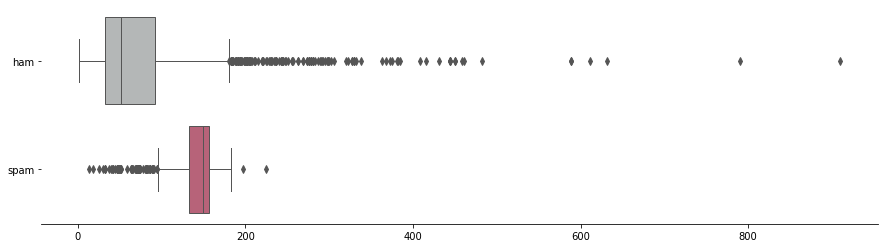

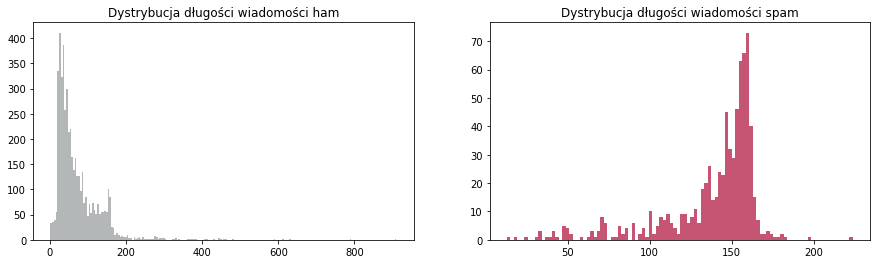

In [45]:
f,ax = plt.subplots(figsize=(15,4))
bx = sns.boxplot(x=data['length'],y=data['spam'],palette=clr,linewidth=1)
despine()
f,ax = plt.subplots(1,2,figsize=(15,4))
h1 = data[data['spam']=='ham']['length'].hist(grid=False,bins=200,ax=ax[0],color=clr[0])
h2 = data[data['spam']=='spam']['length'].hist(grid=False,bins=100,color=clr[1],ax=ax[1])
h1.set_title('Dystrybucja długości wiadomości ham');
h2.set_title('Dystrybucja długości wiadomości spam');

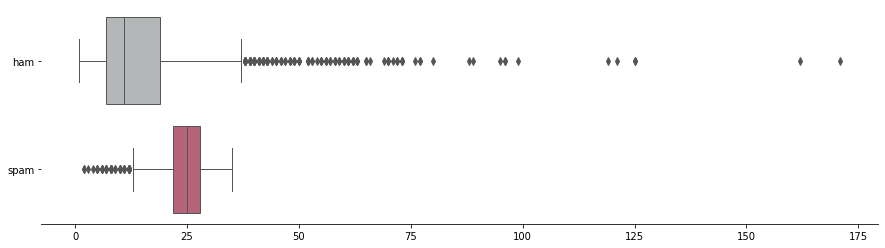

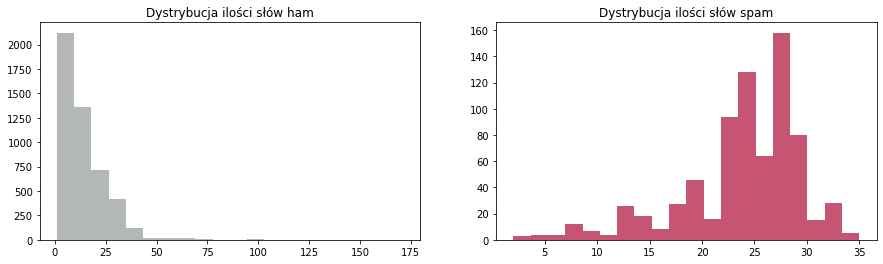

In [48]:
f,ax = plt.subplots(figsize=(15,4))
bx = sns.boxplot(x=data['words_number'],y=data['spam'],palette=clr,linewidth=1)
despine()
f,ax = plt.subplots(1,2,figsize=(15,4))
h1 = data[data['spam']=='ham']['words_number'].hist(grid=False,bins=20,ax=ax[0],color=clr[0])
h2 = data[data['spam']=='spam']['words_number'].hist(grid=False,bins=20,color=clr[1],ax=ax[1])
h1.set_title('Dystrybucja ilości słów ham');
h2.set_title('Dystrybucja ilości słów spam');

Z powyższych wykresów możemy wywnioskować, że większość wiadomości, które nie były spamem ma długość poniżej 100, podczas gdy wiadomości określone jako spam mają długość około 140-160. Jeśli chodzi o ilość słów to sytuacja wygląda analogicznie. Średnio w wiadomościach określonych jako spam mamy 24 słowa, natomiast w wiadomościach, które niezostaly określone spamem mamy średnio 14 słów. Praktycznie wszystkie wiadomości, które nie są spamem mają mniej niż 50 słów, natomiast wiadomości, które są spamem mają mniej niż 35 słów. Najliczniejsza grupa w przypadku spamu to przedział od 22-30 słów.  